In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.dummy import DummyClassifier
import h5py
import mat4py
import matplotlib.pyplot as plt
import math
from sklearn.feature_selection import RFE
from sklearn.model_selection import RandomizedSearchCV
import time

# Ignoring warning messages in output
import warnings
warnings.filterwarnings('ignore')

from eyepunisher import *

In [2]:
%%capture

# WORK IN PROGRESS 
# Trigonometry tricks
"""
x1 = 0
x2 = 60
y1 = 0
y2 = 0

dist = get_dist([x1, y1], [x2, y2])

dist_in_mm = dist * 0.417

theta = math.atan(dist_in_mm/1400)
theta
"""

In [3]:
%%capture

# Example of currently emplyed method, delete later...

"""
p1 = [511.786549, 380.663875]
p2 = [511.976476, 380.416866]

dist = get_dist(p1, p2)

def dist_angles_pr_sec(dist):
    refresh_rate = 500
    return (dist * 0.01666666666666666666666666666667) * refresh_rate

dist_angles_pr_sec(dist)
"""

In [4]:
# Get participant data from file and remove nan values
path = "Doves"
particip_data_doves = pd.read_excel(path+'/DOVES_Observer_Details.xls', header=2)
particip_data_doves.dropna(subset = ['Age'], inplace=True)

# Get list of filenames
file_names = os.listdir(path+'/Fixations')
del file_names[0]

# Load fixation data from files
data_doves = []
for f in file_names:
    data_doves.append(mat4py.loadmat(path+'/Fixations/'+f))

# Load raw data from files
rawdata_doves = punish_all_eyes(path+'/RawData', debug=False)

# Generate a list of the order of participants. Used for selecting correct data from raw data dictionary
subject_ordered_list = data_doves[0]['subj_names_list']
for num, sub in enumerate(subject_ordered_list):
    split = sub.split('.', 1)
    subject_ordered_list[num] = split[0]

Converting ABT2.eye...
Converting ACB2.eye...
Converting AV2.eye...
Converting BSQ2.eye...
Converting BW2.eye...
Converting CE2.eye...
Converting CLM2.eye...
Converting CMG2.eye...
Converting CNG2.eye...
Converting CS2.eye...
Converting FMT2.eye...
Converting GK2.eye...
Converting HRS2.eye...
Converting IVDL2.eye...
Converting JLS2.eye...
Converting JM2.eye...
Converting JNK2.eye...
Converting JSS2.eye...
Converting KAC2.eye...
Converting KW2.eye...
Converting LKC2.eye...
Converting LW2.eye...
Converting MPF2.eye...
Converting NSS2.eye...
Converting RGR2.eye...
Converting SCP2.eye...
Converting TT2.eye...
Converting UR2.eye...
Converting YL2.eye...


### Participant Data:

In [5]:
# Print statistics of participant data
print(f"DOVES Max age: {particip_data_doves.Age.max()}, min age: {particip_data_doves.Age.min()}, mean age: {particip_data_doves.Age.mean()}")
print(f"DOVES Number of females: {particip_data_doves.Gender.value_counts()[0]}, number of males: {particip_data_doves.Gender.value_counts()[1]}")

DOVES Max age: 45.0, min age: 16.0, mean age: 26.586206896551722
DOVES Number of females: 18, number of males: 11


### Feature Selection

In [6]:
# Generate lists of ages and gender from dataframe
gender_list = particip_data_doves.Gender.tolist()
age_list = particip_data_doves.Age.tolist()

In [7]:
# Utility for getting distance bewteen two points
def get_dist(p1, p2):
    dist = math.sqrt(((p1[0]-p2[0])**2)+((p1[1]-p2[1])**2))
    return dist

# Utility for calculating centroid
def get_centroid(arr):
    length = arr.shape[0]
    sum_x = np.sum(arr[:, 0])
    sum_y = np.sum(arr[:, 1])
    return [sum_x/length, sum_y/length]

# Utility for calculating velocity in degrees/sec, takes dist in pixels
def dist_angles_pr_sec(dist):
    refresh_rate = 500
    return (dist * 0.01666666666666666666666666666667) * refresh_rate

In [8]:
# DOVES feature extraction from raw data
# rawdata_doves["subject"] is all data for 1 user, with each index being an image.

# I-VT method for fixations and saccades
# Lists of point belonging to fixations or saccades are generated
raw_fixations = []
raw_saccades = []
raw_pupils = []
for i in range(len(file_names)):
    for j in range(len(subject_ordered_list)):
        local_sacc = []
        local_fix = []
        local_ms = []
        raw_pupils.append(rawdata_doves[subject_ordered_list[j]][i][:-1,2])
        for k in range(len(rawdata_doves[subject_ordered_list[j]][i]) - 1):
            #print(j, i, k)
            p1 = [
                rawdata_doves[subject_ordered_list[j]][i][k][0], 
                rawdata_doves[subject_ordered_list[j]][i][k][1],
            ]
            p2 = [
                rawdata_doves[subject_ordered_list[j]][i][k+1][0], 
                rawdata_doves[subject_ordered_list[j]][i][k+1][1]
            ]
            my_dist = get_dist(p1, p2)
            if my_dist > 2:
                local_sacc.append(p1)
                local_fix.append('-')
                local_ms.append('-')
            else:
                local_fix.append(p1)
                local_sacc.append('-')
                local_ms.append('-')
        
        # Remove stand-alone fixations from fixation list and add to saccades
        for ii in range(1, len(local_fix)-1):
            if local_fix[ii] != '-' and local_fix[ii-1] == '-' and local_fix[ii+1] == '-':
                local_sacc[ii] = local_fix[ii]
                local_fix[ii] = '-'
        
        raw_fixations.append(local_fix)
        raw_saccades.append(local_sacc)

In [9]:
# Raw data microsaccade extraction following > 3 degrees/s velocity and < 100 degrees/s velocity

raw_microsaccades = []
for entry in raw_fixations:
    entry = [[3000, 3000] if item == '-' else item for item in entry]
    local_ms = []
    for i in range(len(entry)-1):
        p1 = [entry[i][0], entry[i][1]]
        p2 = [entry[i+1][0], entry[i+1][1]]
        dist = get_dist(p1, p2)
        if dist_angles_pr_sec(dist) > 3 and dist_angles_pr_sec(dist) < 100:
            local_ms.append(p1)
        else:
            local_ms.append('-')
    
    raw_microsaccades.append(local_ms)
    
    # Sorter microsaccades fra der er under 20 ms (10 i træk da vi har 500hz)

In [10]:
# Microsaccade refinement. Saccades are grouped and removed if under 10.

prev = 'init'

processed_microsaccades = []
for entry in raw_microsaccades:
    if entry[0] == '-':
        prev = '-'
    else:
        prev = 'point'
    
    entry_ms_list = []
    ind_ms_list = []
    ind_time_list = []
    for i in range(len(entry)):
        if entry[i] != '-':
            ind_ms_list.append(entry[i])
            ind_time_list.append(i)
            prev = 'point'
        elif entry[i] == '-':
            if prev == 'point':
                if len(ind_ms_list) > 9:
                    arr_ind_ms_list = np.array(ind_ms_list)
                    entry_ms_list.append([
                        ind_ms_list, ind_time_list[0], len(ind_time_list)
                    ])
                    ind_ms_list = []
                    ind_time_list = []
                    prev = '-'
                else:
                    ind_ms_list = []
                    ind_time_list = []
                    prev = '-'
    processed_microsaccades.append(entry_ms_list)

In [11]:
# I-VT refinement. Fixations are grouped, and lists of format <x, y, t, d> are returned, with x, y being centroids,
# t being the time of first point, and d is duration.

prev = 'init'

processed_fixations = []
processed_pupils = []
for ind, entry in enumerate(raw_fixations):
    pupil_entry = raw_pupils[ind]
    if entry[0] == '-':
        prev = '-'
    else:
        prev = 'point'
    
    entry_fix_list = []
    ind_fix_list = []
    ind_time_list = []
    temp_pupil_list = []
    for i in range(len(entry)):
        if entry[i] != '-':
            ind_fix_list.append(entry[i])
            ind_time_list.append(i)
            temp_pupil_list.append(pupil_entry[i])
            prev = 'point'
        elif entry[i] == '-':
            if prev == 'point':
                arr_ind_fix_list = np.array(ind_fix_list)
                centroid = get_centroid(arr_ind_fix_list)
                entry_fix_list.append([
                    centroid[0], centroid[1], ind_time_list[0], 
                    len(ind_time_list), np.mean(temp_pupil_list), ind_fix_list
                ])
                ind_fix_list = []
                ind_time_list = []
                prev = '-'
    processed_fixations.append(entry_fix_list)
    
    #Processed_fixations : X, Y, Timestamp, Duration, mean pupil diameter

In [12]:
# Similair for saccades, but returns instead of centroid, a list of saccade points, start time and duration

prev = 'init'

processed_saccades = []
for entry in raw_saccades:
    if entry[0] == '-':
        prev = '-'
    else:
        prev = 'point'
    
    entry_sacc_list = []
    ind_sacc_list = []
    ind_time_list = []
    for i in range(len(entry)):
        if entry[i] != '-':
            ind_sacc_list.append(entry[i])
            ind_time_list.append(i)
            prev = 'point'
        elif entry[i] == '-':
            if prev == 'point':
                entry_sacc_list.append([ind_sacc_list, ind_time_list[0], len(ind_time_list)])
                ind_sacc_list = []
                ind_time_list = []
                prev = '-'
    processed_saccades.append(entry_sacc_list)

In [13]:
%%capture

# NEW METHOD ADDED TO THE END OF NOTEBOOK
"""
features = pd.DataFrame(columns=['starttime','duration', 'meanPupilDiameter', 'eventType', 'meanX', 'meanY'])

for i, fix in enumerate(processed_fixations):
    #Processed_fixations : X, Y, Timestamp, Duration, mean pupil diameter
    try:
        feats = pd.DataFrame({
            'starttime': fix[2],
            'duration': fix[3],
            'meanPupilDiameter': fix[4],
            'eventType': 'fixation',
            'meanX': fix[0],
            'meanY': fix[1]
        })

        features = pd.concat([features, feats], ignore_index = True, axis = 0)
    except:
        print("Missing features at index", i)

features.head()
#To do here:
#Sort each entry after start time
#Reverse whole dataframe row-wise (concat adds to top, we don't want that.)
"""

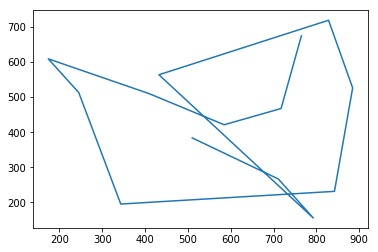

In [14]:
X = data_doves[0]['fix_data'][2][0]
Y = data_doves[0]['fix_data'][2][1]

plt.plot(X, Y)

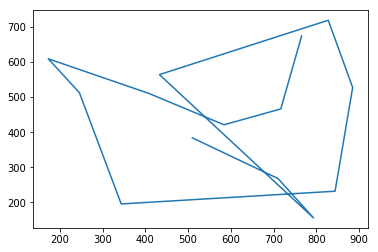

In [15]:
X = np.array(processed_fixations[2])[:,:1]
Y = np.array(processed_fixations[2])[:,1:2]

plt.plot(X, Y)

In [16]:
# Feature extraction like below, but from new data WOOHOO

# -+Features to extract+-
# Fixations
mean_fixdur = []
sd_fixdur = []
max_fixdur = []
min_fixdur = []
total_fixdur = []
n_fix = []

# Saccades
mean_saccdur = []
sd_saccdur = []
max_saccdur = []
min_saccdur = []
total_saccdur = []
n_sacc = []

# Scanpath
mean_sp_len = []
sd_sp_len = []
max_sp_len = []
min_sp_len = []
total_sp_len = []

# Pupil diameter
mean_pd = []
sd_pd = []
max_pd = []
min_pd = []
total_pd = []

# Microsaccades - new method
total_amount_ms = []
mean_ms_len = []
sd_ms_len = []
max_ms_len = []
min_ms_len = []
total_ms_len = []

# Microsaccades2 - old method
mean_ms_len2 = []
sd_ms_len2 = []
total_ms_len2 = []

# Meta
n_fix_by_n_sacc = []

for item in processed_fixations:
    np_item = np.array(item)
    mean_fixdur.append(np.mean(np_item[:,3:4]))
    sd_fixdur.append(np.std(np_item[:,3:4]))
    max_fixdur.append(int(max(np_item[:,3:4])))
    min_fixdur.append(int(min(np_item[:,3:4])))
    total_fixdur.append(int(sum(np_item[:,3:4])))
    
    n_fix.append(len(np_item))
    
    sp_dists = []
    for i in range(len(np_item)-1):
        p1 = [np_item[i][0], np_item[i][1]]
        p2 = [np_item[i+1][0], np_item[i+1][1]]
        sp_dists.append(get_dist(p1, p2))
    if len(sp_dists) > 0:
        mean_sp_len.append(np.mean(sp_dists))
        sd_sp_len.append(np.std(sp_dists))
        max_sp_len.append(max(sp_dists))
        min_sp_len.append(min(sp_dists))
        total_sp_len.append(sum(sp_dists))
    else:
        mean_sp_len.append(0)
        sd_sp_len.append(0)
        max_sp_len.append(0)
        min_sp_len.append(0)
        total_sp_len.append(0)
        
    ms_dists2 = []
    for alt in np_item[:,5:6]:
        for i in range(len(alt[0])-1):
            p1 = [alt[0][i][0], alt[0][i][1]]
            p2 = [alt[0][i+1][0], alt[0][i+1][1]]
            ms_dists2.append(get_dist(p1, p2))
    if len(ms_dists2) > 0:
        mean_ms_len2.append(np.mean(ms_dists2))
        sd_ms_len2.append(np.std(ms_dists2))
        total_ms_len2.append(sum(ms_dists2))
    else:
        mean_ms_len2.append(0)
        sd_ms_len2.append(0)
        total_ms_len2.append(0)
        
    mean_pd.append(np.mean(np_item[:,4:5]))
    sd_pd.append(np.std(np_item[:,4:5]))
    max_pd.append(int(max(np_item[:,4:5])))
    min_pd.append(int(min(np_item[:,4:5])))
    total_pd.append(int(sum(np_item[:,4:5])))

for item in processed_saccades:
    np_item = np.array(item)
    n_sacc.append(len(item))
    mean_saccdur.append(np.mean(np_item[:,2:3]))
    sd_saccdur.append(np.std(np_item[:,2:3]))
    max_saccdur.append(int(max(np_item[:,2:3])))
    min_saccdur.append(int(min(np_item[:,2:3])))
    total_saccdur.append(int(sum(np_item[:,2:3])))
    
for item in processed_microsaccades:
    ms_dists = []
    total_amount_ms.append(len(item))
    for ms in item:
        for i in range(len(ms[0])-1):
            p1 = [ms[0][i][0], ms[0][i][1]]
            p1 = [ms[0][i+1][0], ms[0][i+1][1]]
            ms_dists.append(get_dist(p1, p2))
    if len(ms_dists) > 0:
        mean_ms_len.append(np.mean(ms_dists))
        sd_ms_len.append(np.std(ms_dists))
        total_ms_len.append(sum(ms_dists))
        max_ms_len.append(max(ms_dists))
        min_ms_len.append(min(ms_dists))
    else:
        mean_ms_len.append(0)
        sd_ms_len.append(0)
        total_ms_len.append(0)
        max_ms_len.append(0)
        min_ms_len.append(0)
        
for i in range(len(total_fixdur)):
    n_fix_by_n_sacc.append(total_fixdur[i]/total_saccdur[i])

    
# Create a feature vector and append it to X
X = []
for i in range(len(mean_fixdur)):
    X.append([
        mean_fixdur[i], sd_fixdur[i], max_fixdur[i],
        min_fixdur[i], total_fixdur[i], n_fix[i],
        mean_sp_len[i], sd_sp_len[i], max_sp_len[i], 
        min_sp_len[i], total_sp_len[i], mean_pd[i], 
        sd_pd[i], max_pd[i], min_pd[i], 
        total_pd[i], mean_ms_len[i], sd_ms_len[i],
        total_ms_len[i], total_amount_ms[i], n_fix_by_n_sacc[i],
        max_ms_len[i], min_ms_len[i], mean_saccdur[i],
        sd_saccdur[i], max_saccdur[i], min_saccdur[i],
        total_saccdur[i]
    ])

In [17]:
# The feature vector
X[0]

[60.333333333333336,
 29.322725354615695,
 142,
 23,
 905,
 15,
 117.2807275729853,
 122.12861698836844,
 472.14380213526823,
 1.7249012039355043,
 1641.9301860217943,
 0.2714474764031886,
 0.09514537209831349,
 0,
 0,
 4,
 212.26139555159983,
 74.61578887203646,
 11037.592568683192,
 5,
 7.418032786885246,
 324.2199557734526,
 117.9379190003882,
 8.133333333333333,
 2.6297443897754693,
 12,
 3,
 122]

In [18]:
# Y definition

# Gender Y
Y = []

for img_entry in data_doves:
    for i in range(len(img_entry['fix_data'])):
        Y.append(gender_list[i])
        
for i in range(len(Y)):
    if Y[i] == 'M':
        Y[i] = 0
    elif Y[i] == 'F':
        Y[i] = 1
        

# Age Y
alt_Y = []

for img_entry in data_doves:
    for i in range(len(img_entry['fix_data'])):
        alt_Y.append(age_list[i])
        
for i in range(len(alt_Y)):
    if alt_Y[i] >= 27:
        alt_Y[i] = 0
    elif alt_Y[i] < 27:
        alt_Y[i] = 1

In [19]:
# Remove nan's from the X values and replace them with 0
for i in range(len(X)):
    for j in range(len(X[i])):
        if math.isnan(X[i][j]):
            X[i][j] = 0

In [20]:
mean_pd[0]

0.2714474764031886

### Classification

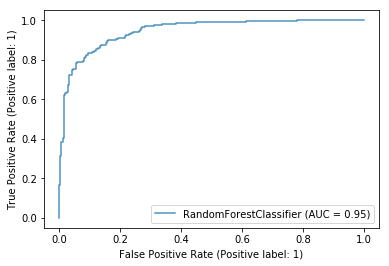

In [21]:
# Random Forest

X = np.array(X)
y = np.array(Y)

model = RandomForestClassifier(
    n_estimators=1000, criterion='entropy', min_samples_split=5,
    min_samples_leaf=1, random_state=42, max_features='sqrt'
)

acc_score = []
f1 = []
recall = []
precision = []

k = 5
kf = KFold(n_splits=k, shuffle=False)
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    model.fit(X_train,y_train)
    pred_values = model.predict(X_test)
    
    acc_score.append(accuracy_score(y_test, pred_values))
    f1.append(f1_score(y_test, pred_values))
    precision.append(precision_score(y_test, pred_values))
    recall.append(recall_score(y_test, pred_values))

ax = plt.gca()
rfc_disp = plot_roc_curve(model, X_test, y_test, ax=ax, alpha=0.8)
    
rfc_avg_acc_score = sum(acc_score)/k
rfc_avg_f1_score = sum(f1)/k
rfc_avg_recall = sum(recall)/k
rfc_avg_precision = sum(precision)/k


Random forest classifier results:
Avg. acc. = 0.8514938304016801
Avg. F1 = 0.7935752107568707
Avg. recall = 0.7540468400822382
Avg. precision = 0.8375518248605107

Dummy classifier results:
Avg. acc. = 0.6206878445786296
Avg. F1 = 0.0
Avg. recall = 0.0
Avg. precision = 0.0



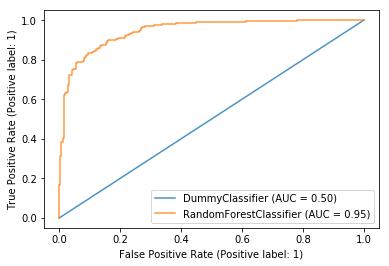

In [22]:
# Dummy Classifier

X = np.array(X)
y = np.array(Y)

model = DummyClassifier(strategy="most_frequent")

acc_score = []
f1 = []
recall = []
precision = []

k = 5
kf = KFold(n_splits=k, shuffle=False)
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    model.fit(X_train,y_train)
    pred_values = model.predict(X_test)
    
    acc_score.append(accuracy_score(y_test, pred_values))
    f1.append(f1_score(y_test, pred_values))
    precision.append(precision_score(y_test, pred_values))
    recall.append(recall_score(y_test, pred_values))

ax = plt.gca()
d_disp = plot_roc_curve(model, X_test, y_test, ax=ax, alpha=0.8)
rfc_disp.plot(ax=ax, alpha=0.8)
    
d_avg_acc_score = sum(acc_score)/k
d_avg_f1_score = sum(f1)/k
d_avg_recall = sum(recall)/k
d_avg_precision = sum(precision)/k

print(f"""
Random forest classifier results:
Avg. acc. = {rfc_avg_acc_score}
Avg. F1 = {rfc_avg_f1_score}
Avg. recall = {rfc_avg_recall}
Avg. precision = {rfc_avg_precision}

Dummy classifier results:
Avg. acc. = {d_avg_acc_score}
Avg. F1 = {d_avg_f1_score}
Avg. recall = {d_avg_recall}
Avg. precision = {d_avg_precision}
""")


### Features as dataframe

In [23]:
features = pd.DataFrame(columns=['starttime','duration', 'meanPupilDiameter', 'eventType', 'meanX', 'meanY'])
features

,starttime,duration,meanPupilDiameter,eventType,meanX,meanY


In [26]:
list_of_features_dfs = []
for i in range(len(processed_fixations)):
    if i%250 == 0:
        print(f"{i} of {len(processed_fixations)} done!")
    features = pd.DataFrame(columns=['starttime','duration', 'meanPupilDiameter', 'eventType', 'meanX', 'meanY'])
    
    for item in processed_fixations[i]:
        features = features.append({
            'starttime' : item[2], 'duration' : item[3], 'meanPupilDiameter' : item[4], 
            'eventType' : 'fixation', 'meanX' : item[0], 'meanY' : item[1]
        }, ignore_index=True)
        
    for item in processed_saccades[i]:
        np_item = np.array(item[0])
        features = features.append({
            'starttime' : item[1], 'duration' : item[2], 
            'meanPupilDiameter' : np.mean(raw_pupils[i][item[1]:(item[1]+item[2]+1)]), 
            'eventType' : 'saccade', 'meanX' : np.mean(np_item[:,0:1]), 'meanY' : np.mean(np_item[:,0:1])
        }, ignore_index=True)
    
    list_of_features_dfs.append(features)
print("All done!")

0 of 2929 done!
250 of 2929 done!
500 of 2929 done!
750 of 2929 done!
1000 of 2929 done!
1250 of 2929 done!
1500 of 2929 done!
1750 of 2929 done!
2000 of 2929 done!
2250 of 2929 done!
2500 of 2929 done!
2750 of 2929 done!
All done!


In [27]:
list_of_features_dfs[0].sort_values(by=['starttime'])

,starttime,duration,meanPupilDiameter,eventType,meanX,meanY
0,0,142,0.149380,fixation,511.194913,379.576964
15,142,8,0.126136,saccade,469.137437,469.137437
1,150,36,0.134456,fixation,453.877694,425.332784
16,186,10,0.115960,saccade,306.088309,306.088309
2,196,49,0.141475,fixation,274.122368,377.674386
17,245,10,0.355230,saccade,302.756827,302.756827
3,255,63,0.311627,fixation,316.548627,242.488026
18,318,11,0.814397,saccade,298.091982,298.091982
4,329,37,0.292885,fixation,294.962129,441.094175
19,366,12,0.022627,saccade,550.630846,550.630846
